## LSTM-Model for Text Generation

Some reference on LSTMs:
* Colah, <https://colah.github.io/posts/2015-08-Understanding-LSTMs/>
* Pytorch tutorial, <https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html>
* Text Generation With Pytorch, <https://machinetalk.org/2019/02/08/text-generation-with-pytorch/>
* Language Modelling and Text Generation using LSTMs — Deep Learning for NLP, <https://medium.com/@shivambansal36/language-modelling-text-generation-using-lstms-deep-learning-for-nlp-ed36b224b275>

![Text generation](https://machinetalk.org/wp-content/uploads/2019/02/predict.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import os
from collections import Counter
from argparse import Namespace
import logging

logger = logging.getLogger(__name__)
logger.setLevel(level = logging.INFO)
handler = logging.FileHandler("lstm-5.log")
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

flags = Namespace(
    train_file_path='dict_no_stop_jieba',
    checkpoint_path='checkpoint',
    seq_size=32,
    batch_size=64,
    embedding_size=128,
    lstm_size=128,
    gradients_norm=5,
    top_k=5,
    num_epochs=40,
    learning_rate=0.001
)

logger.info(str(flags))
if not os.path.exists(flags.checkpoint_path):
    os.mkdir(flags.checkpoint_path)

In [2]:
from torch.utils import data

class TextDataset(data.Dataset):
    """
    My own text dataset
    ref: https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
    """
    def __init__(self, file_path, batch_size, seq_size):
        """
        Generate word indices and dictionary used for training

        file_path: The path of the folder storing all the news
        batch_size: size of one batch (used for batch training)
        seq_size: size of the sequence
        """
        text = []
        for i,file_name in enumerate(os.listdir(file_path),1):
            with open("{}/{}".format(file_path,file_name),"r",encoding="utf-8") as infile:
                for j,line in enumerate(infile):
                    text += line.split()
        word_counts = Counter(text) # {word: count}
        # sort based on counts, but only remain the word strings
        sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)

        # make embedding based on the occurance frequency of the words
        self.int_to_word = {k: w for k, w in enumerate(sorted_vocab)}
        self.word_to_int = {w: k for k, w in self.int_to_word.items()}
        self.n_word = len(self.int_to_word)
        print('Vocabulary size', self.n_word)

        # turn all the words in the text to int
        int_text = [self.word_to_int[w] for w in text]
        num_batches = int(len(int_text) / (seq_size * batch_size))
        in_text = int_text[:num_batches * batch_size * seq_size]

        # shift right for one position to generate the 'label' Y
        out_text = np.zeros_like(in_text)
        out_text[:-1] = in_text[1:]
        out_text[-1] = in_text[0]

        # reshape X and Y (# of seq,seq_size)
        self.in_text = np.reshape(in_text,(-1,seq_size))
        self.out_text = np.reshape(out_text,(-1,seq_size))
        self.seq_size = seq_size
#     return int_to_word, word_to_int, n_word, in_text, out_text

    def __len__(self):
        """
        Return the total number of samples
        """
        return len(self.in_text)
    
    def __getitem__(self, idx):
        """
        Generate one sample of the data
        """
        x = self.in_text[idx]
        y = self.out_text[idx]
        return x, y

![LSTM Basic Unit](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

In [3]:
class RNNModule(nn.Module):
    """
    A basic LSTM model for text generation
    """
    def __init__(self, n_word, seq_size, embedding_size, lstm_size):
        super(RNNModule, self).__init__()
        self.seq_size = seq_size
        self.lstm_size = lstm_size
        
        # embed = nn.Embedding(vocab_size, vector_size)
        # `vocab_size` is the number of words in your train, val and test set
        # `vector_size` is the dimension of the word vectors you are using
        # you can view it as a linear transformation
        # the tensor is initialized randomly
        self.embedding = nn.Embedding(n_word, embedding_size)
        
        self.lstm = nn.LSTM(embedding_size, lstm_size, batch_first=True)
        self.linear = nn.Linear(lstm_size, n_word)

    def forward(self, x, prev_state):
        """
        Forward propagation
        """
        embedding = self.embedding(x)
        # used for next layer
        output, state = self.lstm(embedding, prev_state)
        # used for output
        logits = self.linear(output)
        return logits, state

    def zero_state(self, batch_size):
        """
        Used to make the state all zeros
        """
        return (torch.zeros(1, batch_size, self.lstm_size),
                torch.zeros(1, batch_size, self.lstm_size))

In [4]:
import time, sys

def train():
    """
    Core training function
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_set = TextDataset(flags.train_file_path, flags.batch_size, flags.seq_size)
    train_loader = data.DataLoader(dataset=train_set,batch_size=flags.batch_size,shuffle=False)

    net = RNNModule(train_set.n_word, flags.seq_size, flags.embedding_size, flags.lstm_size)
    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=flags.learning_rate)

    iteration = 0
    losses = []

    start_time = time.time()
    for e in range(flags.num_epochs):
        state_h, state_c = net.zero_state(flags.batch_size)
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        
        for step, (x, y) in enumerate(train_loader):
            iteration += 1
            net.train()

            optimizer.zero_grad()

            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            logits, (state_h, state_c) = net(x, (state_h, state_c))
            loss = criterion(logits.transpose(1, 2), y)

            loss_value = loss.item()

            loss.backward()

            # avoid delivering loss from h_t and c_t
            # thus need to remove them from the computation graph
            state_h = state_h.detach()
            state_c = state_c.detach()

            # avoid gradient explosion
            _ = torch.nn.utils.clip_grad_norm_(net.parameters(), flags.gradients_norm)

            optimizer.step()
            losses.append(loss_value)

            if iteration % 100 == 0:
                print('Epoch: {}/{}'.format(e+1, flags.num_epochs),
                      'Iteration: {}'.format(iteration),
                      'Loss: {}'.format(loss_value))
                logger.info('Epoch: {}/{} Iteration: {} Loss: {}'.format(e+1, flags.num_epochs, iteration, loss_value))

            if iteration % 1000 == 0:
                torch.save(net.state_dict(),
                           '{}/model-{}.pth'.format(flags.checkpoint_path,iteration))

    print("Time:{}s".format(time.time()-start_time))
    torch.save(net.state_dict(),'{}/model-{}.pth'.format(flags.checkpoint_path,"final"))
    return net, losses

In [5]:
if __name__ == "__main__":
    net, losses = train()

Vocabulary size 48469
Epoch: 1/40 Iteration: 100 Loss: 7.927405834197998
Epoch: 1/40 Iteration: 200 Loss: 7.559329509735107
Epoch: 1/40 Iteration: 300 Loss: 7.860358238220215
Epoch: 1/40 Iteration: 400 Loss: 7.498166084289551
Epoch: 2/40 Iteration: 500 Loss: 7.301557540893555
Epoch: 2/40 Iteration: 600 Loss: 7.3907151222229
Epoch: 2/40 Iteration: 700 Loss: 7.1585564613342285
Epoch: 2/40 Iteration: 800 Loss: 7.161759853363037
Epoch: 3/40 Iteration: 900 Loss: 6.438643932342529
Epoch: 3/40 Iteration: 1000 Loss: 6.713354587554932
Epoch: 3/40 Iteration: 1100 Loss: 6.914454936981201
Epoch: 3/40 Iteration: 1200 Loss: 7.107439994812012
Epoch: 3/40 Iteration: 1300 Loss: 6.821282386779785
Epoch: 4/40 Iteration: 1400 Loss: 6.807150840759277
Epoch: 4/40 Iteration: 1500 Loss: 7.3239288330078125
Epoch: 4/40 Iteration: 1600 Loss: 7.0144829750061035
Epoch: 4/40 Iteration: 1700 Loss: 6.422833442687988
Epoch: 5/40 Iteration: 1800 Loss: 5.858368396759033
Epoch: 5/40 Iteration: 1900 Loss: 6.21303033828735

In [15]:
"""
The following part is used for prediction and generating the answers
"""

import jieba

stopwords = [word[:-1] for word in open("stopwords.txt","r",encoding="utf-8")] # delete \n

def generate_seg_lst(lst):
    cut_lst = jieba.lcut(lst,cut_all=False)
    res = []
    for word in cut_lst:
        if word not in stopwords and word != "\n":
            res.append(word)
    return res

def predict(device, net, question_str, n_word, word_to_int, int_to_word, top_k=5):
    """
    Use `net` to do the prediction
    Each time only one `question_str` is input
    """
    net.eval() # set in evaluation mode
    # find out the blank
    q_index = question_str.index("[MASK]")
    question_pre, question_post = question_str[:q_index], question_str[q_index+len("[MASK]"):]

    # cut the sentence
    seg_pre = generate_seg_lst(question_pre)
    seg_post = generate_seg_lst(question_post)
    seg_pre.insert(0,"<BOS>")
    seg_post.insert(len(seg_post),"<EOS>")

    # LSTM inference
    state_h, state_c = net.zero_state(1)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    for w in seg_pre:
        index = word_to_int.get(w,word_to_int["<BOS>"])
        ix = torch.tensor([[index]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

    # get the topk prediction
    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()

    # return the corresponding words
    return [int_to_word[x] for x in choices[0]]

top_k = 5 # flags.top_k
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_set = TextDataset(flags.train_file_path, flags.batch_size, flags.seq_size)

# load from previous models
net = RNNModule(train_set.n_word, flags.seq_size,flags.embedding_size, flags.lstm_size)
net.load_state_dict(torch.load("checkpoint/model-10000.pth"))
net.to(device)

groundtrue = [line[:-1] for line in open("answer.txt","r",encoding="utf-8")]
acc = 0

myanswer = open("myanswer-lstm-{}.txt".format(top_k),"w",encoding="utf-8")

print("Use LSTM model to predict")
with open("questions.txt","r",encoding="utf-8") as question_file:
    for i,question_str in enumerate(question_file,1):
        pred = predict(device, net, question_str, train_set.n_word, train_set.word_to_int, train_set.int_to_word, top_k)
        if groundtrue[i-1] in pred:
            acc += 1
            print("{}√ [MASK] = {} - {}".format(i,pred,groundtrue[i-1]),flush=True)
        else:
            print("{} [MASK] = {} - {}".format(i,pred,groundtrue[i-1]),flush=True)
        myanswer.write("{}\n".format(" ".join(pred)))

print("Accuracy: {:.2f}%".format(acc))

Vocabulary size 48469
Use LSTM model to predict
1 [MASK] = ['咀嚼', 'logo', '吐槽', '马自达', 'Davis'] - 座椅
2 [MASK] = ['到来', '<EOS>', '更', '新', '诞生'] - 汽车
3 [MASK] = ['采访', '媒体', '<EOS>', '澎湃', 'CNN'] - 欧洲
4 [MASK] = ['工艺', '视角', '风格', '设计', '徕'] - 玻璃
5 [MASK] = ['华为', '<EOS>', '做生意', '苹果', '一家'] - 利润
6 [MASK] = ['屏幕', '<EOS>', '贫穷', '买', '绑定'] - 故宫
7 [MASK] = ['客户', '生产', '减员', '<EOS>', '准入'] - 颁发
8√ [MASK] = ['<EOS>', '广阔', '看好', '企业', '关注'] - 广阔
9 [MASK] = ['<EOS>', '力量', '合作', '探索', '各个环节'] - 对话
10√ [MASK] = ['时间', '手机', '系列', '量产', '新'] - 手机
11 [MASK] = ['<EOS>', '信息', '数量', '相关', '升级'] - 神经网络
12 [MASK] = ['新', '工具', '用户', '未来', '带来'] - 机器人
13 [MASK] = ['攻城略地', '饱和', '份额', '更', '机会'] - 应用
14√ [MASK] = ['增长', '下滑', '收入', '约', '盈利'] - 增长
15 [MASK] = ['<EOS>', '测试', '最终', '特斯拉', '更'] - 学习
16 [MASK] = ['业余', '5G', '体系', '商用', '技术'] - 门店
17 [MASK] = ['<EOS>', 'APP', '动力系统', '旅游', '10'] - 干燥
18 [MASK] = ['人士', '管理条例', '反对', '原厂', '10'] - 政府
19√ [MASK] = ['<EOS>', '5G', '厂商', '营业厅', '行业'] - 厂商

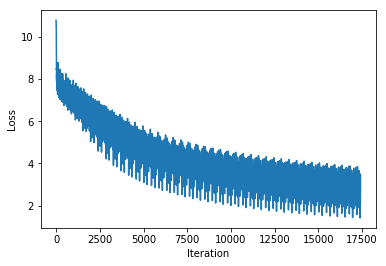

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.savefig(r"train_loss.pdf",format="pdf",dpi=200)
plt.show()